# X-ray detected Be star catalog

**Caden Gobat**<sup>1</sup> & **Hui Yang**<sup>1</sup>

<sup>1</sup>The George Washington University

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, pickle, seaborn as sns, sympy, matplotlib as mpl
from scipy import stats, optimize
from gdpyc import GasMap, DustMap
from astropy.io import fits, votable, ascii as ascii_io
import astropy.units as u
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord, Angle
from astroquery.vizier import Vizier
from astroquery.xmatch import XMatch
from astroquery.simbad import Simbad
from astropy.table import Table

from collections import Counter
from matplotlib.lines import Line2D

import warnings
warnings.filterwarnings('ignore')

pd.set_option('max_columns', None)

In [2]:
BeSS = ascii_io.read("./catalogs/BeSS_catalog.csv", format="csv", header_start=0, data_start=1)
BeSS['_RAJ2000']= Angle(BeSS['RA'], 'hourangle').degree*u.degree 
BeSS['_DEJ2000'] = Angle(BeSS['DEC'], 'deg').degree*u.degree 
BeSS.pprint()

 #    Be star    Category ...       _RAJ2000            _DEJ2000     
                          ...         deg                 deg        
---- ---------- --------- ... ------------------- -------------------
   1 BD+62 2346 Classical ... 0.35291666666666666   63.50436944444444
   2  HD 224905 Classical ... 0.41095833333333326   60.44992222222222
   3  HD 225095 Classical ...  0.8631249999999999   55.55089722222222
   4      2 Cet Classical ...  0.9349583333333332 -17.335991666666665
   5     10 Cas Classical ...  1.6105833333333333   64.19616944444445
   6 BD+59 2829 Classical ...  1.7012499999999997  60.600230555555555
   7    BD+62 1 Classical ...            1.888125   63.08032777777778
   8   BD+62 11 Classical ...  2.6954999999999996  63.172936111111106
   9   V742 Cas Classical ...   2.904791666666666   58.21182777777778
  10   EM* AS 2 Classical ...  3.2468749999999997   66.32206388888889
 ...        ...       ... ...                 ...                 ...
2255   V817 Cas Clas

In [3]:
indexs =    [68,        42,         47,         49,         230,       237,        253,      272,       274,        260,      296,     1630]

gaia_ras =  [13.02345,   12.142170,  12.306773,  12.374212,  14.400078,14.552446,  15.262034,16.290251, 16.480222,  15.467899,19.633210,215.300650]
gaia_decs = [-72.434514, -73.042030, -73.193853, -73.182921, -72.326132,-72.513544,-72.116379,-72.196375,-72.064044,-72.392790,63.742520,-62.698914]


for ind, ra, dec in zip(indexs, gaia_ras, gaia_decs):
    BeSS[ind]['_RAJ2000'], BeSS[ind]['_DEJ2000'] = ra, dec 

print(BeSS[indexs][['Be star','_RAJ2000','_DEJ2000']])
    
BeSS['conf_flag'] = 0

indexs =    [760,      767,      150,       215,       516,      857,       1410,      1478,      1604,      2074,      189,      1715,      1930,      139]

gaia_ras =  [80.124405,80.691452,13.957651, 14.157500, 34.809579,83.920304, 165.624950,174.743251,207.402686,303.730549,14.074344,241.011158,274.692197,13.896433]
gaia_decs = [-69.532146,33.416338,-72.452880,-72.302182,57.184698,-66.864928,-60.815525,-63.476778,-42.473011,36.853563,-72.467921,-47.477649,-13.910324,-72.485176]

for ind, ra, dec in zip(indexs, gaia_ras, gaia_decs):
    BeSS[ind]['_RAJ2000'], BeSS[ind]['_DEJ2000'], BeSS[ind]['conf_flag'] = ra, dec, 2 
    # those are questionable matches confirmed later 

print(BeSS[indexs][['Be star','_RAJ2000','_DEJ2000']])

       Be star         _RAJ2000  _DEJ2000 
                         deg       deg    
--------------------- --------- ----------
            X SMC X-3  13.02345 -72.434514
      RX J0048.5-7302  12.14217  -73.04203
      RX J0049.2-7311 12.306773 -73.193853
      RX J0049.5-7310 12.374212 -73.182921
CXOU J005736.2-721934 14.400078 -72.326132
      RX J0058.2-7231 14.552446 -72.513544
      RX J0101.0-7206 15.262034 -72.116379
      RX J0105.3-7210 16.290251 -72.196375
      RX J0105.9-7203 16.480222 -72.064044
      RX J0101.8-7223 15.467899  -72.39279
            CAS GAM-1  19.63321   63.74252
           4U 1416-62 215.30065 -62.698914
       Be star          _RAJ2000   _DEJ2000 
                          deg        deg    
---------------------- ---------- ----------
            [HP99] 946  80.124405 -69.532146
 Cl* NGC 1893 CUF 3104  80.691452  33.416338
      Cl* NGC 330 G 68  13.957651  -72.45288
Cl* NGC 330 ELS 004509    14.1575 -72.302182
          NGC 869 1164  34.809579  57.18

In [4]:
def find_nearest(df, ind_col='_q', sep_col='_r', check=False, drop=False):
    
    '''
    drop multiple matches for the source with the same ind_col column by keeping the nearest match of sep_col column
    '''
    
    print('Before cleaning multiple matches:', len(df), 'rows.')
    df_nearest = pd.DataFrame(columns=[ind_col])
    for i in df[ind_col].unique():
        df_sub = df.loc[df[ind_col]==i]
        instances = len(df_sub)
        if instances == 0:
            pass
        elif drop and i in drop:
            pass
        else:
            if check and instances>1:
                print(df_sub)
                
            df_src = df_sub.loc[df_sub[sep_col] ==min(df_sub[sep_col])]
            if len(df_src)>1:
                df_nearest = pd.concat([df_nearest, df_src.head(1)])
            else:
                df_nearest = pd.concat([df_nearest, df_src])
    print('After cleaning multiple matches:', len(df_nearest), 'rows.')
    return df_nearest

In [5]:
# matching to gaiaedr3

v = Vizier(columns=['all', '_RAJ2000', '_DEJ2000', "_r"])
v.ROW_LIMIT = -1 # no row limit
v.TIMEOUT = 99999 # big time limit

# match BeSS to gaiaedr3 using 2"
Gaia_BeSS_2as = v.query_region(BeSS, catalog="I/350/gaiaedr3", radius="2s")
Gaia_matched = Gaia_BeSS_2as[0]["_q","_r","_RAJ2000","_DEJ2000","EDR3Name","Source","Plx","pmRA","pmDE","epsi","sepsi","RUWE","Gmag","BPmag","RPmag","Tefftemp"]

gaia_df = Gaia_matched.to_pandas()
gaia_df = gaia_df.dropna(subset=['_r'])
gaia_df['Source'] = gaia_df.apply(lambda row: np.int64(row.EDR3Name[10:]), axis=1)
gaia_df = find_nearest(gaia_df, ind_col='Source', sep_col='_r', check=False, drop=False)

Before cleaning multiple matches: 2491 rows.
After cleaning multiple matches: 2469 rows.


In [6]:
# match BeSS to gaiaedr3dist using 2"

Gaiadist_BeSS_1as = v.query_region(BeSS, catalog="I/352/gedr3dis", radius="2s")
Gaiadist_matched = Gaiadist_BeSS_1as[0]["_q","_r","Source","rgeo","b_rgeo","B_rgeo","rpgeo","b_rpgeo","B_rpgeo","Flag"]

gaiadist_df = Gaiadist_matched.to_pandas()
gaiadist_df = find_nearest(gaiadist_df, ind_col='Source', sep_col='_r', check=False, drop=False)

Before cleaning multiple matches: 2326 rows.
After cleaning multiple matches: 2311 rows.


In [7]:
# combining gaiaedr3 and gaiaedr3dist matching results and calculating color BP-RP and absolute magnitude of BPmag

df_gaia_comb = pd.merge(gaia_df, gaiadist_df, on='Source', how="outer")

df_gaia_comb['_q'] = df_gaia_comb['_q_x']

df_gaia_comb['BP-RP'] = df_gaia_comb['BPmag']-df_gaia_comb['RPmag']

df_gaia_comb['abs_BPmag'] = df_gaia_comb['BPmag']-5*(np.log10(df_gaia_comb['rgeo'])-1)

In [8]:
# dropping those multiple/unlikely matches with larger separations and no magnitude and distance measurements

print('Before dropping unlikely matches:',len(df_gaia_comb))

for i in df_gaia_comb['_q'].unique():
    df_sub = df_gaia_comb.loc[df_gaia_comb['_q']==i]
    instances = len(df_sub)
    if instances >= 2:

        sep_min = min(df_sub['_r_x'])
        drop_idx = df_gaia_comb[(df_gaia_comb['_q'] == i) & (df_gaia_comb['_r_x'] !=sep_min) & (df_gaia_comb['abs_BPmag'].isnull()) ].index
        #print(df_gaia_comb.loc[drop_idx])
        df_gaia_comb.drop(drop_idx, inplace = True)
        
print('After dropping unlikely matches:',len(df_gaia_comb))

Before dropping unlikely matches: 2469
After dropping unlikely matches: 2214


Text(0, 0.5, 'Absolute BPmag')

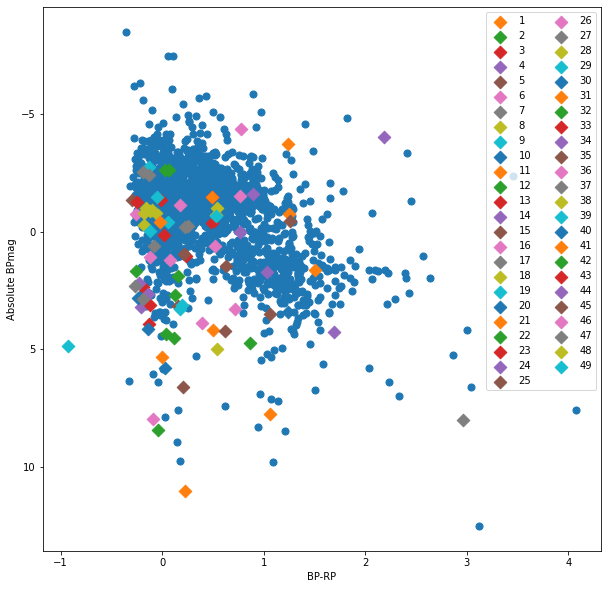

In [9]:
# marking questionable gaia counterparts of BeSS stars with multiple matches using conf_flag_gaia column 
# plotting the distributions of those questionable matches in HR diagram in diamonds compared to others in dots

df_gaia_comb['conf_flag_gaia'] = 0

fig, ax = plt.subplots(figsize=(10,10))

ax.scatter(df_gaia_comb['BP-RP'], df_gaia_comb['abs_BPmag'], s=50)

j=1
for i in df_gaia_comb['_q'].unique():
    df_sub = df_gaia_comb.loc[df_gaia_comb['_q']==i]
    instances = len(df_sub)
    if instances == 1:
        pass
    else:
        df_gaia_comb.loc[df_gaia_comb['_q']==i, 'conf_flag_gaia'] += 1
        ax.scatter(df_sub['BP-RP'], df_sub['abs_BPmag'], s=80, marker='D',label=j)
        #print(j, df_sub[['_q','_r_x','Source','_RAJ2000','_DEJ2000','BP-RP','abs_BPmag']])
        j += 1
        
plt.legend(ncol=2)
plt.gca().invert_yaxis()
plt.xlabel('BP-RP')
plt.ylabel('Absolute BPmag')

In [10]:
# We take the closest counterparts for those questionable.multiple gaia counterparts 
 
df_gaia = find_nearest(df_gaia_comb, ind_col='_q', sep_col='_r_x')

Before cleaning multiple matches: 2214 rows.
After cleaning multiple matches: 2164 rows.


In [11]:
# Combining BeSS catalog and gaia catalog 

df_BeSS = BeSS.to_pandas()
df_comb = pd.merge(df_BeSS[['#','Be star','_RAJ2000', '_DEJ2000','V','Type','conf_flag']],
                   df_gaia.drop(columns=['_q_x','_r_x','_q_y', '_r_y']),
                   left_on="#", right_on="_q", how="outer")
print(df_comb.columns)

Index(['#', 'Be star', '_RAJ2000_x', '_DEJ2000_x', 'V', 'Type', 'conf_flag',
       '_q', 'Source', '_RAJ2000_y', '_DEJ2000_y', 'EDR3Name', 'Plx', 'pmRA',
       'pmDE', 'epsi', 'sepsi', 'RUWE', 'Gmag', 'BPmag', 'RPmag', 'Tefftemp',
       'rgeo', 'b_rgeo', 'B_rgeo', 'rpgeo', 'b_rpgeo', 'B_rpgeo', 'Flag',
       'BP-RP', 'abs_BPmag', 'conf_flag_gaia'],
      dtype='object')


In [12]:
# Using gaia coordinates rather than BeSS coordinates, unless there is no gaia match for BeSS stars
df_comb['_RAJ2000'], df_comb['_DEJ2000'] = df_comb['_RAJ2000_y'], df_comb['_DEJ2000_y']
df_comb.loc[df_comb['_RAJ2000'].isnull(), '_RAJ2000'] = df_comb.loc[df_comb['_RAJ2000'].isnull(), '_RAJ2000_x']
df_comb.loc[df_comb['_DEJ2000'].isnull(), '_DEJ2000'] = df_comb.loc[df_comb['_DEJ2000'].isnull(), '_DEJ2000_x']

# forward-matching to X-ray catalogs

In [13]:
# matching to X-ray catalogs, for 2SXPS we can use the 2sxps version or the 2sxpscle clean version

cat_ids = ["IX/57/csc2master","IX/59/xmm4dr9s","IX/58/2sxpscle"] 
xmatch = [None, None, None]
radii = ["2s","5s","9s"]
for i in range(len(cat_ids)):
    xmatch[i] = v.query_region(BeSS, catalog=cat_ids[i], radius=radii[i])
    print("Successfully matched BeSS with",cat_ids[i])
[CSC_xmatch, XMM_xmatch, XRT_xmatch] = xmatch

Successfully matched BeSS with IX/57/csc2master
Successfully matched BeSS with IX/59/xmm4dr9s
Successfully matched BeSS with IX/58/2sxpscle


In [14]:
Chandra_sources = CSC_xmatch[0]["_q","_r","_RAJ2000","_DEJ2000","_2CXO", 'HRhm', 'HRhs', 'HRms',
                                'Fluxh', 'B_Fluxh', 'b_Fluxh', 'Fluxm', 'B_Fluxm', 'b_Fluxm', 'Fluxs',
                                'B_Fluxs', 'b_Fluxs', 'Fluxu', 'B_Fluxu', 'b_Fluxu', 'GamPL', 'NHPL'].to_pandas()
chandra_bands = {"b":(0.5,7), "h":(2,7), "m":(1.2,2), "s":(0.5,1.2), "u":(0.2,0.5)}

XMM_sources = XMM_xmatch[0]["_q","_r","_RAJ2000","_DEJ2000","_4XMM",'Flux1', 'e_Flux1',
       'Flux2', 'e_Flux2', 'Flux3', 'e_Flux3', 'Flux4', 'e_Flux4', 'Flux5',
       'e_Flux5', 'Flux8', 'e_Flux8', 'Flux9', 'e_Flux9', 'HR1', 'e_HR1',
       'HR2', 'e_HR2', 'HR3', 'e_HR3', 'HR4', 'e_HR4'].to_pandas()
xmm_bands = dict(zip(list("1234589"),[(0.2,0.5),(0.5,1.0),(1.0,2.0),(2.0,4.5),(4.5,12.0),(0.2,12.0),(0.5,4.5)]))

XRT_sources = XRT_xmatch[0]["_q","_r","_RAJ2000","_DEJ2000",'_2SXPS', 'CR0', 'E_CR0', 'e_CR0', 'HR1', 'HR2', 'CR1',
       'e_CR1', 'CR2', 'E_CR2', 'e_CR2', 'CR3', 'E_CR3', 'e_CR3', 'PcstS0',
       'FPO0', 'FPU0', 'Gam1', 'E_Gam1', 'e_Gam1'].to_pandas()

In [15]:
# checking the multiple matches from X-ray catalogs 
for df in [Chandra_sources, XMM_sources, XRT_sources]:
    display(df[df.duplicated(subset=['_q'], keep=False)])

,_q,_r,_RAJ2000,_DEJ2000,_2CXO,HRhm,HRhs,HRms,Fluxh,B_Fluxh,b_Fluxh,Fluxm,B_Fluxm,b_Fluxm,Fluxs,B_Fluxs,b_Fluxs,Fluxu,B_Fluxu,b_Fluxu,GamPL,NHPL
36,892,0.886,84.727452,26.315550,J053854.5+261855X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37,892,0.259,84.727417,26.315725,J053854.5+261856,0.58339,0.77327,0.34603,2.900373e-12,2.939407e-12,2.861339e-12,2.314897e-13,2.366342e-13,2.260237e-13,6.522526e-14,6.806354e-14,6.238699e-14,6.920638e-14,8.897963e-14,4.844447e-14,0.561029,32.6370
47,1456,0.235,172.778935,-62.946932,J113106.9-625648,0.67208,0.93067,0.68582,2.563811e-12,2.698679e-12,2.428944e-12,1.385348e-13,1.528730e-13,1.241967e-13,1.292182e-14,1.748246e-14,8.107809e-15,0.000000e+00,2.899199e-14,0.000000e+00,0.065576,48.8438
48,1456,0.847,172.779145,-62.946756,J113106.9-625648X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,_q,_r,_RAJ2000,_DEJ2000,_4XMM,Flux1,e_Flux1,Flux2,e_Flux2,Flux3,e_Flux3,Flux4,e_Flux4,Flux5,e_Flux5,Flux8,e_Flux8,Flux9,e_Flux9,HR1,e_HR1,HR2,e_HR2,HR3,e_HR3,HR4,e_HR4


,_q,_r,_RAJ2000,_DEJ2000,_2SXPS,CR0,E_CR0,e_CR0,HR1,HR2,CR1,e_CR1,CR2,E_CR2,e_CR2,CR3,E_CR3,e_CR3,PcstS0,FPO0,FPU0,Gam1,E_Gam1,e_Gam1


In [16]:
# taking the closest counterpart
df_CSC = find_nearest(Chandra_sources, ind_col='_q', sep_col='_r').reset_index(drop=True)
df_XMM = find_nearest(XMM_sources, ind_col='_q', sep_col='_r').reset_index(drop=True)
df_XRT = find_nearest(XRT_sources, ind_col='_q', sep_col='_r').reset_index(drop=True)

Before cleaning multiple matches: 80 rows.
After cleaning multiple matches: 78 rows.
Before cleaning multiple matches: 103 rows.
After cleaning multiple matches: 103 rows.
Before cleaning multiple matches: 61 rows.
After cleaning multiple matches: 61 rows.


In [17]:
# merging X-ray catalog matching results

xray = pd.merge(df_CSC, df_XMM, on="_q", how="outer")
xray = pd.merge(xray, df_XRT, on="_q", how="outer")

print(len(xray))

152


In [18]:
# renaming some columns 

xray.rename(columns={'_r_x':'_r_CSC','_RAJ2000_x':'_RAJ2000_CSC','_DEJ2000_x':'_DEJ2000_CSC',
                     '_r_y':'_r_XMM','_RAJ2000_y':'_RAJ2000_XMM','_DEJ2000_y':'_DEJ2000_XMM',
                     '_r':'_r_XRT','_RAJ2000':'_RAJ2000_XRT','_DEJ2000':'_DEJ2000_XRT',
                     "HR1_x":"HR1","HR2_x":"HR2","HR1_y":"SwiftHR1","HR2_y":"SwiftHR2"},inplace=True)

print(xray.columns)

Index(['_q', '_r_CSC', '_RAJ2000_CSC', '_DEJ2000_CSC', '_2CXO', 'HRhm', 'HRhs',
       'HRms', 'Fluxh', 'B_Fluxh', 'b_Fluxh', 'Fluxm', 'B_Fluxm', 'b_Fluxm',
       'Fluxs', 'B_Fluxs', 'b_Fluxs', 'Fluxu', 'B_Fluxu', 'b_Fluxu', 'GamPL',
       'NHPL', '_r_XMM', '_RAJ2000_XMM', '_DEJ2000_XMM', '_4XMM', 'Flux1',
       'e_Flux1', 'Flux2', 'e_Flux2', 'Flux3', 'e_Flux3', 'Flux4', 'e_Flux4',
       'Flux5', 'e_Flux5', 'Flux8', 'e_Flux8', 'Flux9', 'e_Flux9', 'HR1',
       'e_HR1', 'HR2', 'e_HR2', 'HR3', 'e_HR3', 'HR4', 'e_HR4', '_r_XRT',
       '_RAJ2000_XRT', '_DEJ2000_XRT', '_2SXPS', 'CR0', 'E_CR0', 'e_CR0',
       'SwiftHR1', 'SwiftHR2', 'CR1', 'e_CR1', 'CR2', 'E_CR2', 'e_CR2', 'CR3',
       'E_CR3', 'e_CR3', 'PcstS0', 'FPO0', 'FPU0', 'Gam1', 'E_Gam1', 'e_Gam1'],
      dtype='object')


In [19]:
def bandshift(fluxA,bandA,bandB,Gamma=1.7):
    a1,a2 = bandA
    b1,b2 = bandB
    if Gamma == 2:
        integral = lambda lower,upper : np.log(upper) - np.log(lower)
    else:
        integral = lambda lower,upper : (upper**(2-Gamma) - lower**(2-Gamma))/(2-Gamma)
    scalar = fluxA/integral(a1,a2)
    fluxB = scalar*integral(b1,b2)
    return fluxB

# total flux and power-law spectrum-based flux splitting into Swift bands
for i in xray[xray["_2SXPS"].notna()].index:
    total = xray.loc[i,"FPO0"]
    gamma = xray.loc[i,"Gam1"]
    if pd.isna(gamma):
        gamma = 2

    xray.loc[i,"XRTsoft"] = bandshift(total,(0.3,10),(0.3,1),gamma)
    xray.loc[i,"XRTmed"] = bandshift(total,(0.3,10),(1,2),gamma)
    xray.loc[i,"XRThard"] = bandshift(total,(0.3,10),(2,10),gamma)

In [20]:
CSC_fluxs = ['Fluxs', 'Fluxm', 'Fluxh']
XMM_fluxs = ['Flux1', 'Flux2', 'Flux3', 'Flux4', 'Flux5']
XRT_fluxs = ['XRTsoft', 'XRTmed', 'XRThard']

for i,row in xray.iterrows():
    flag = []
    if pd.notna(row["_2CXO"]):
        flag.append("CXO")
    if pd.notna(row["_4XMM"]):
        flag.append("XMM")
    if pd.notna(row["_2SXPS"]):
        flag.append("XRT")
    flag = "+".join(flag)
    if len(flag)<3:
        flag = np.nan
    xray.loc[i,"Flag"] = flag

xray.dropna(subset=["Flag"],inplace=True)
    
xray["Flux45"] = xray.Flux4 + xray.Flux5

xray = xray.replace(0,1e-17)

xray["Flag"].value_counts()

XMM            43
CXO+XMM        24
CXO            24
CXO+XMM+XRT    22
XRT            17
XMM+XRT        14
CXO+XRT         8
Name: Flag, dtype: int64

In [21]:
# Determining X-ray coordinates [_RAJ2000_X, _DEJ2000_X] in an order of CSC, XMM, XRT

for i in xray[xray["_2CXO"].notna() | xray["_4XMM"].notna() | xray["_2SXPS"].notna()].index:
    cxoflux, xmmflux, xrtflux = xray.loc[i,CSC_fluxs].values, xray.loc[i,XMM_fluxs].values, xray.loc[i,XRT_fluxs].values

    if all(pd.notna(cxoflux)): # good Chandra observations present
        
        ra, dec = xray.loc[i,"_RAJ2000_CSC"], xray.loc[i,"_DEJ2000_CSC"]
        source = "CXO"
    elif all(pd.notna(xmmflux)): # no Chandra, but good XMM
        
        ra, dec = xray.loc[i,"_RAJ2000_XMM"], xray.loc[i,"_DEJ2000_XMM"]
        source = "XMM"
    elif all(pd.notna(xrtflux)): # neither Chandra nor XMM, but good Swift-XRT
        ra, dec = xray.loc[i,"_RAJ2000_XRT"], xray.loc[i,"_DEJ2000_XRT"]
        source = "XRT"
    else:
        continue
    
    xray.loc[i,"_RAJ2000_X"], xray.loc[i,"_DEJ2000_X"] = ra, dec
    xray.loc[i,"X_pos"] = source

xray["N_H"] = GasMap.nh(SkyCoord(xray["_RAJ2000_X"], xray["_DEJ2000_X"], unit = 'deg'), nhmap='LAB').value

### Correct absorption

https://heasarc.gsfc.nasa.gov/cgi-bin/Tools/w3pimms/w3pimms.pl

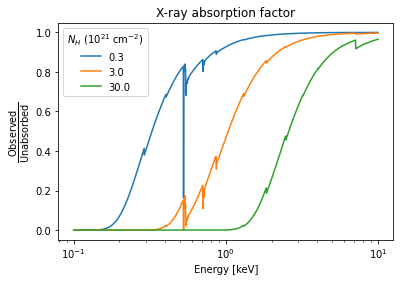

In [22]:
# tbabs from xspec Wilms, Allen & McCray (2000)
tbabs_ene, tbabs_cross = np.loadtxt('./tbabs.data', skiprows=0)
# tbabs_cross # table is in units of 1e22 cm^2, we want to work in 1e24

for nH in [3e20,3e21,3e22]:
    plt.plot(tbabs_ene, np.exp(-nH/1e22 * tbabs_cross),label=nH/1e21)
plt.xscale("log")
plt.xlabel("Energy [keV]")
plt.ylabel(r"$\frac{\mathrm{Observed}}{\mathrm{Unabsorbed}}$", size=14)
plt.legend(title="$N_H\ (10^{21}\ \mathrm{cm}^{-2})$")
plt.title("X-ray absorption factor")
plt.show()

In [23]:
from scipy.interpolate import UnivariateSpline, InterpolatedUnivariateSpline

def red_factor(ene, nH, Gamma, tbabs_ene, tbabs_cross): # energy in keV, nH in cm^-2

    if Gamma == 2:
        flux_unred_int = np.log(ene[1]) - np.log(ene[0])
    else:
        flux_unred_int   = (ene[1]**(2.-Gamma)-ene[0]**(2.-Gamma))/(2.-Gamma)
        
    _ = tbabs_ene**(1 - Gamma) # pseudo spectrum
    tbabs_flux_red = _ * np.exp(-nH/1e22 * tbabs_cross) # extincted spectrum
    
    finterp = InterpolatedUnivariateSpline(tbabs_ene, tbabs_flux_red, k=1)
    
    flux_red_int = finterp.integral(*ene)

    return flux_red_int / flux_unred_int

In [24]:
bands = [(0.2,1),(1,2),(2,12)]
print("Assuming nH = 3e20 and Gamma = 1.7:")
for enes in bands:
    print(f"In the {enes[0]:.1f}-{enes[1]:.1f} keV band we lose {1-red_factor(enes,3e20,1.7,tbabs_ene,tbabs_cross):.1%} of flux due to absorption")

Assuming nH = 3e20 and Gamma = 1.7:
In the 0.2-1.0 keV band we lose 33.9% of flux due to absorption
In the 1.0-2.0 keV band we lose 3.4% of flux due to absorption
In the 2.0-12.0 keV band we lose 13.0% of flux due to absorption


In [25]:
bands = [(0.2,1),(1,2)]
for i,row in xray[xray["Flux2"].notna() & xray["Flux3"].notna() & xray["Flux45"].notna()].iterrows():
    fluxs = row[["Flux2","Flux3"]].values
    unabs = [flux/red_factor(enes,3e20,1.7,tbabs_ene,tbabs_cross) for flux,enes in zip(fluxs,bands)]
    if pd.notna(row["GamPL"]):
        gam = row["GamPL"]
    elif pd.notna(row["Gam1"]):
        gam = row["Gam1"]
    else:
        gam = 2
    NH = row["N_H"]
    reabsorbed = [flux*red_factor(enes,NH,gam,tbabs_ene,tbabs_cross) for flux,enes in zip(unabs,bands)]
    xray.loc[i,["Flux2","Flux3"]] = reabsorbed

## Translate X-ray fluxes

In [26]:
# Determining X-ray fluxes at CXO s,m,h bands in priority of CSC -> XMM -> XRT
# X_pos and X_flux are not necessary coming from the same X-ray catalog since some X-ray catalog has the valid coordinate but the fluxes might be Null
for i in xray[xray["_2CXO"].notna() | xray["_4XMM"].notna() | xray["_2SXPS"].notna()].index:
    cxoflux, xmmflux, xrtflux = xray.loc[i,CSC_fluxs].values, xray.loc[i,XMM_fluxs].values, xray.loc[i,XRT_fluxs].values
    exists = False
    if pd.notna(xray.loc[i,"GamPL"]): # spectral index from Chandra
        Gamma = float(xray.loc[i,"GamPL"])
        exists = True
    elif pd.notna(xray.loc[i,"Gam1"]): # spectral index from Swift
        Gamma = float(xray.loc[i,"Gam1"])
        exists = True
    else: # assumption for general case
        Gamma = 1.7
    
    if all(pd.notna(cxoflux)): # good Chandra observations present
        converted = cxoflux
        source = "CXO"
    elif all(pd.notna(xmmflux)): # no Chandra, but good XMM
        mergedxmm = np.array([xmmflux[1], xmmflux[2], xmmflux[3]+xmmflux[4]])
        origbands = [(0.2,1),(1,2),(2,12)]
        converted = [bandshift(flux,xmmband,cxoband,Gamma) for flux,xmmband,cxoband in
                     zip(mergedxmm,origbands,[(0.5, 1.2), (1.2, 2), (2, 7)])]
        source = "XMM"
    elif all(pd.notna(xrtflux)): # neither Chandra nor XMM, but good Swift-XRT
        origbands = [(0.3,1),(1,2),(2,10)]
        converted = [bandshift(flux,xrtband,cxoband,Gamma) for flux,xrtband,cxoband in
                     zip(xrtflux,origbands,[(0.5, 1.2), (1.2, 2), (2, 7)])]
        source = "XRT"
    else:
        converted = np.nan
        source = np.nan
        continue
    
    xray.loc[i,"Flux (s band)"] = converted[0]
    xray.loc[i,"Flux (m band)"] = converted[1]
    xray.loc[i,"Flux (h band)"] = converted[2]
    xray.loc[i,"X_flux"] = source
    if exists:
        xray.loc[i,"Gamma"] = Gamma
        
xray = xray[['_q', '_2CXO', '_4XMM', '_2SXPS', 'Flag', '_RAJ2000_X', '_DEJ2000_X', 'X_pos', 'Flux (s band)', 'Flux (m band)', 'Flux (h band)', 'X_flux', 'Gamma',
             'Fluxh', 'B_Fluxh', 'b_Fluxh', 'Fluxm', 'B_Fluxm', 'b_Fluxm', 'Fluxs', 'B_Fluxs', 'b_Fluxs', 'Fluxu', 'B_Fluxu', 'b_Fluxu',
             'Flux1', 'e_Flux1', 'Flux2', 'e_Flux2', 'Flux3', 'e_Flux3', 'Flux4', 'e_Flux4', 'Flux5', 'e_Flux5']]

In [27]:
# dropping those with invalid X-ray fluxes
print("dropping:")
display(xray[xray["X_flux"].isna()])

xray = xray.dropna(subset=['X_flux']).reset_index(drop=True)

print(xray[['X_flux','X_pos']].value_counts())

dropping:


,_q,_2CXO,_4XMM,_2SXPS,Flag,_RAJ2000_X,_DEJ2000_X,X_pos,Flux (s band),Flux (m band),Flux (h band),X_flux,Gamma,Fluxh,B_Fluxh,b_Fluxh,Fluxm,B_Fluxm,b_Fluxm,Fluxs,B_Fluxs,b_Fluxs,Fluxu,B_Fluxu,b_Fluxu,Flux1,e_Flux1,Flux2,e_Flux2,Flux3,e_Flux3,Flux4,e_Flux4,Flux5,e_Flux5
23,514.0,J021856.8+570742,NaN,NaN,CXO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e-17,2.702616e-16,1.000000e-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,1608.0,J135217.3-662415,NaN,NaN,CXO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.745817e-16,6.599773e-16,8.918612e-17,5.611409e-16,8.582154e-16,2.475621e-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52,1703.0,J155355.8-235841,NaN,NaN,CXO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.055015e-14,8.472679e-14,7.637350e-14,9.810809e-14,1.029036e-13,9.331257e-14,1.403007e-14,1.772219e-14,1.033794e-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53,1758.0,J163709.5-103401,NaN,NaN,CXO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.986221e-13,4.048792e-13,3.920175e-13,1.486114e-12,1.503035e-12,1.468136e-12,4.405668e-12,4.832830e-12,3.978507e-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


X_flux  X_pos
CXO     CXO      70
XMM     XMM      60
XRT     XRT      18
dtype: int64


43


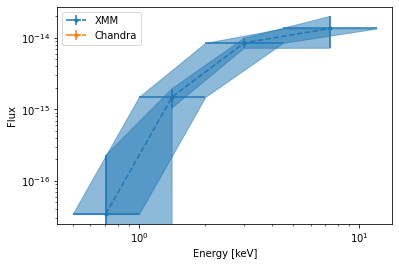

48


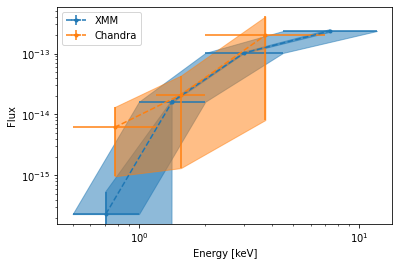

50


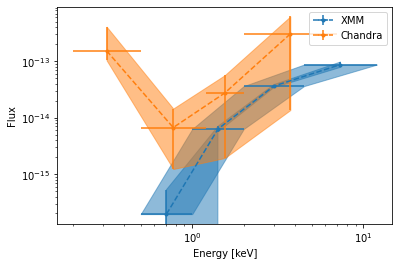

52


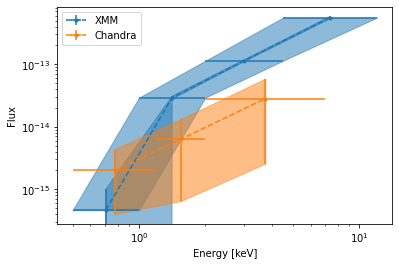

60


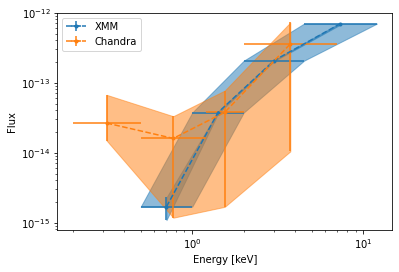

66


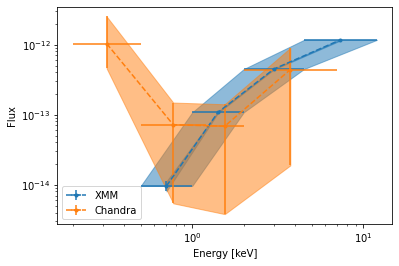

67


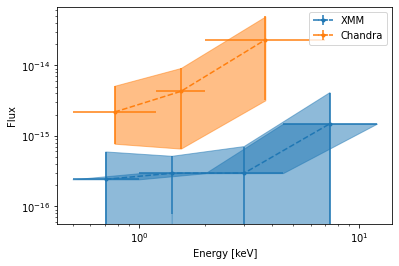

69


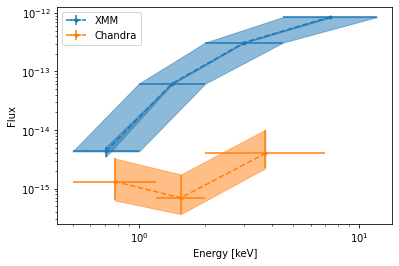

71


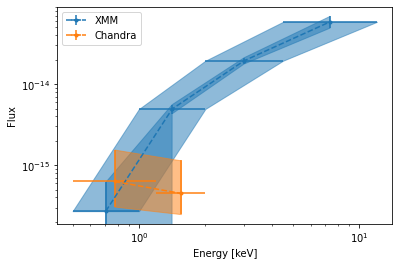

82


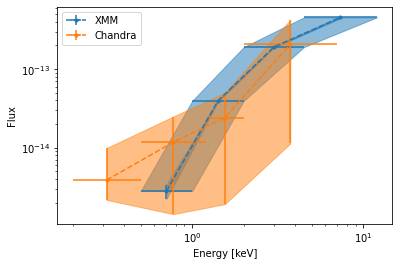

92


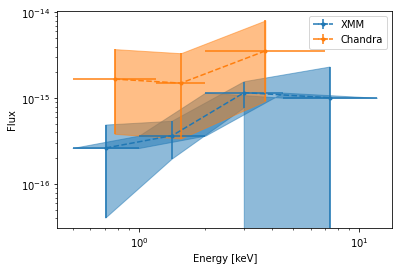

117


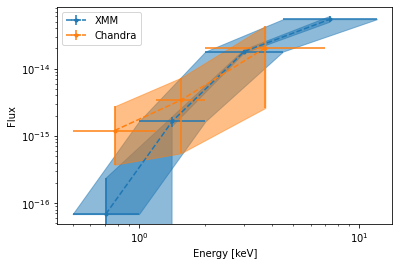

140


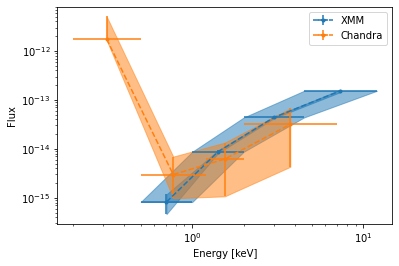

164


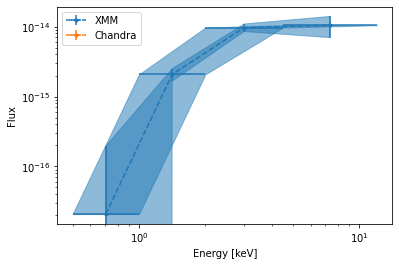

231


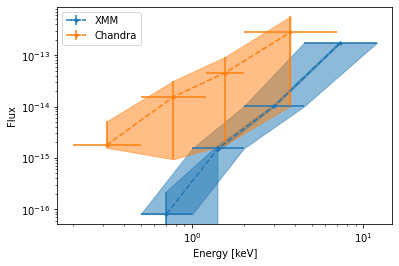

254


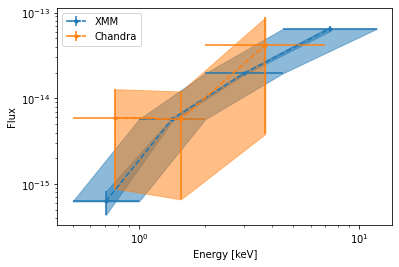

258


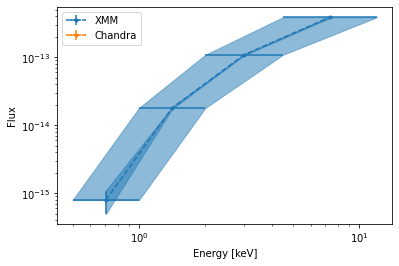

261


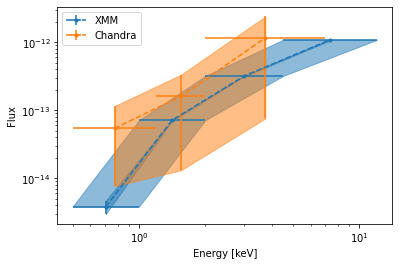

271


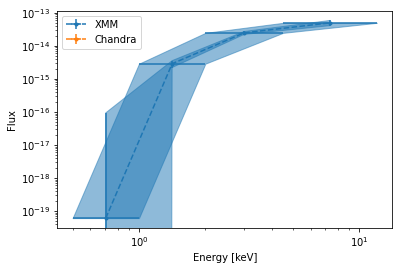

273


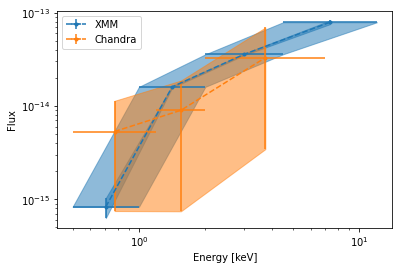

275


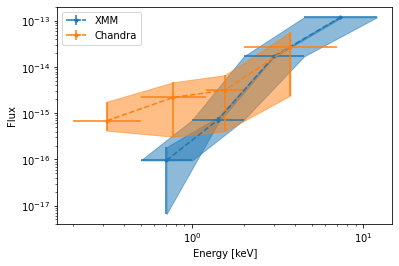

517


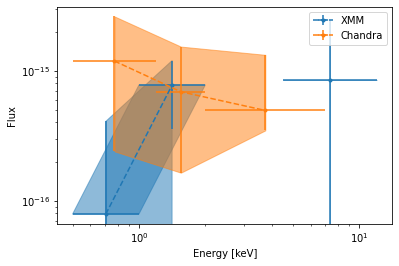

597


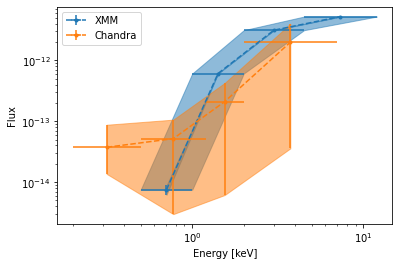

682


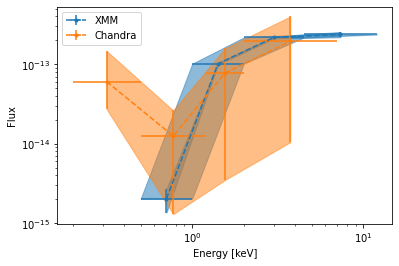

688


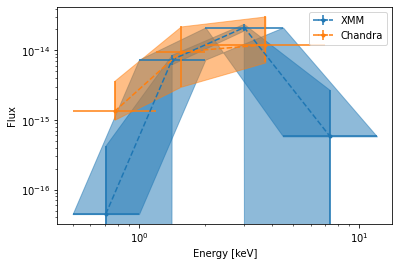

758


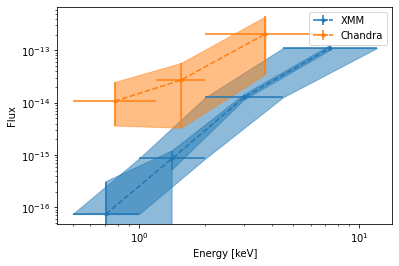

772


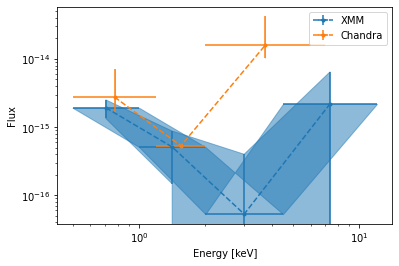

856


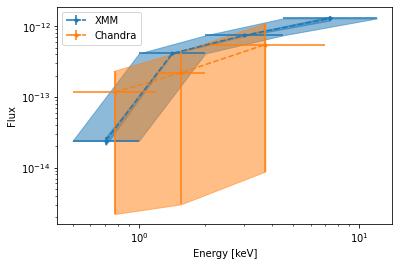

857


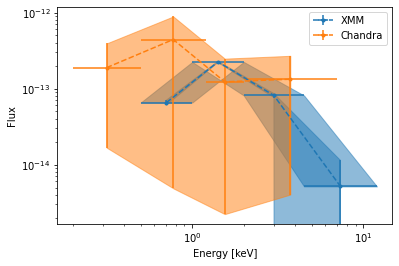

892


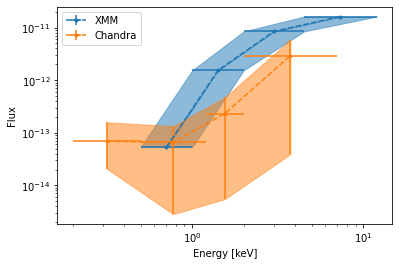

1001


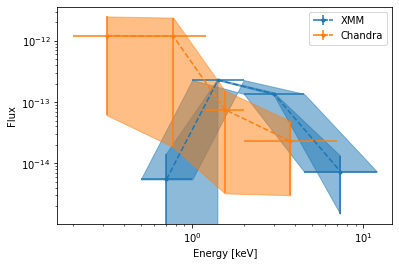

1168


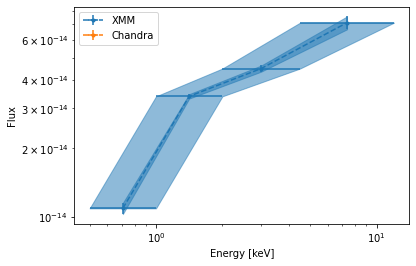

1563


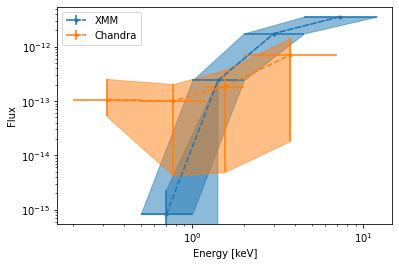

1601


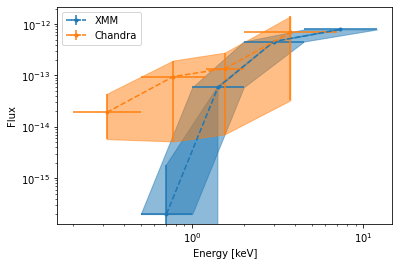

1851


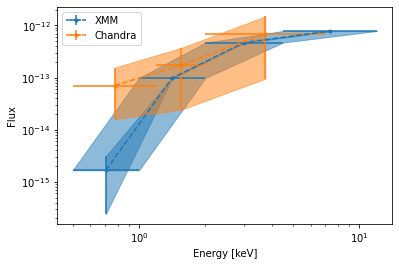

1875


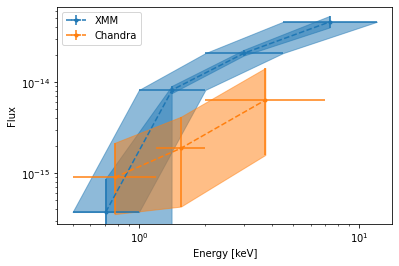

1887


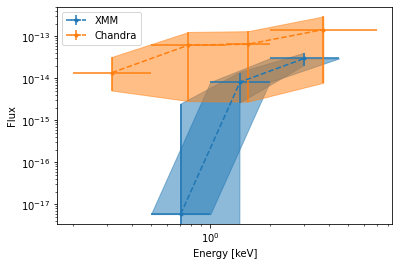

1891


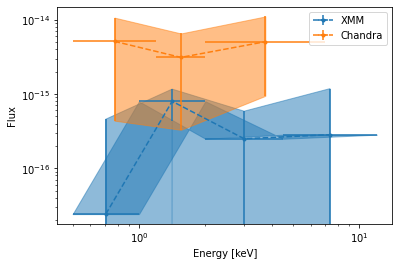

1893


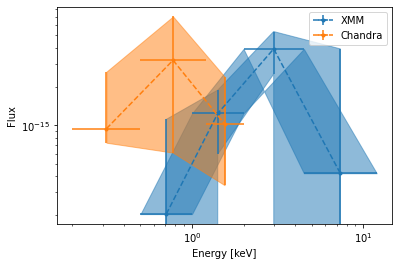

1895


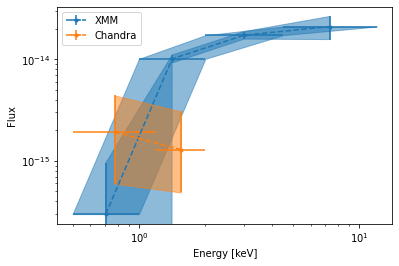

1896


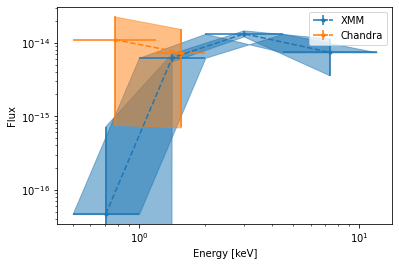

1900


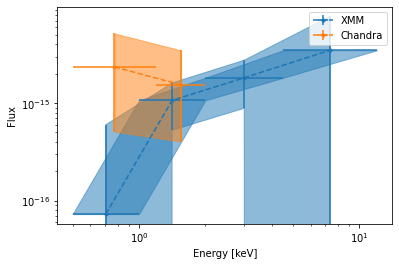

1903


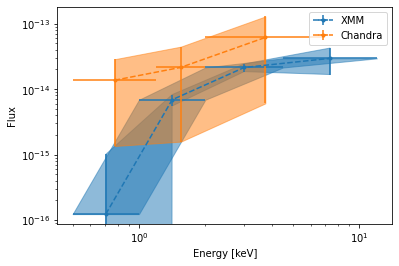

1930


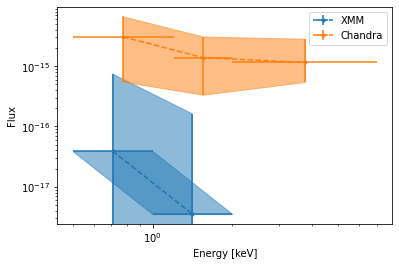

1931


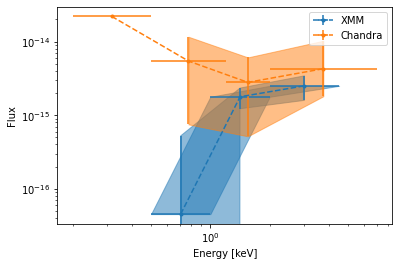

2123


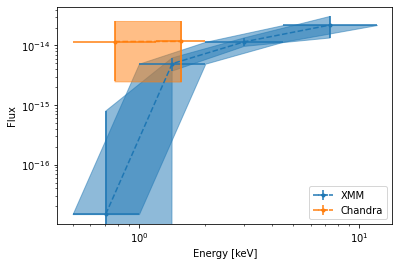

In [28]:
log_mean = lambda x1,x2 : 10**np.mean((np.log10(x1),np.log10(x2)))
xmm_E = np.array([log_mean(0.5,1),log_mean(1,2),log_mean(2,4.5),log_mean(4.5,12)])
cxo_E = np.array([log_mean(0.2,0.5),log_mean(0.5,1.2),log_mean(1.2,2),log_mean(2,7)])
for idx,obj in xray[xray["_2CXO"].notna() & xray["_4XMM"].notna()].iterrows():
    obj = obj.replace(1.0e-17,np.nan)
#     obj = obj.replace(0,np.nan)
    print(int(obj["_q"]))
    plt.errorbar(xmm_E,obj[["Flux2","Flux3","Flux4","Flux5"]],
                 xerr=[xmm_E-np.array([0.5,1,2,4.5]), np.array([1,2,4.5,12])-xmm_E],
                 yerr=obj[["e_Flux2","e_Flux3","e_Flux4","e_Flux5"]],
                 linestyle="--",marker=".",label="XMM")
    lower = obj[["Flux2","Flux3","Flux4","Flux5"]].values - obj[["e_Flux2","e_Flux3","e_Flux4","e_Flux5"]].values
    upper = obj[["Flux2","Flux3","Flux4","Flux5"]].values + obj[["e_Flux2","e_Flux3","e_Flux4","e_Flux5"]].values
    plt.fill_between(xmm_E,np.array(lower,dtype=float),np.array(upper,dtype=float),color="C0",alpha=0.5)
    plt.fill_betweenx(np.array(obj[["Flux2","Flux3","Flux4","Flux5"]].values,dtype=float),[0.5,1,2,4.5],[1,2,4.5,12],
                      color="C0",alpha=0.5)
    plt.errorbar(cxo_E,obj[["Fluxu","Fluxs","Fluxm","Fluxh"]],
                 xerr=[cxo_E-np.array([0.2,0.5,1.2,2]), np.array([0.5,1.2,2,7])-cxo_E],
                 yerr=[obj[["b_Fluxu","b_Fluxs","b_Fluxm","b_Fluxh"]],
                       obj[["B_Fluxu","B_Fluxs","B_Fluxm","B_Fluxh"]]],
                 linestyle="--",marker=".",label="Chandra")
    lower = obj[["Fluxu","Fluxs","Fluxm","Fluxh"]].values - obj[["b_Fluxu","b_Fluxs","b_Fluxm","b_Fluxh"]].values
    upper = obj[["Fluxu","Fluxs","Fluxm","Fluxh"]].values + obj[["B_Fluxu","B_Fluxs","B_Fluxm","B_Fluxh"]].values
    plt.fill_between(cxo_E,np.array(lower,dtype=float),np.array(upper,dtype=float),color="C1",alpha=0.5)
    
    plt.legend()
    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("Energy [keV]")
    plt.ylabel("Flux")
    plt.show()

# backward-matching with gaia counterparts of X-ray sources

In [29]:
radec = xray[['_RAJ2000_X', '_DEJ2000_X']].values
rd = Table(Angle(radec, 'deg'), names=('_RAJ2000', '_DEJ2000'))

X_ga = v.query_region(rd, catalog="I/350/gaiaedr3", radius='9s')[0].to_pandas()
X_ga['Source'] = X_ga.apply(lambda row: np.int64(row.EDR3Name[10:]), axis=1)
X_ga = find_nearest(X_ga, ind_col='Source', sep_col='_r', check=False, drop=False)

X_gaiadist = v.query_region(rd, catalog="I/352/gedr3dis", radius='9s')[0].to_pandas()
X_gaiadist = find_nearest(X_gaiadist, ind_col='Source', sep_col='_r', check=False, drop=False)

X_gaia = pd.merge(X_ga, X_gaiadist, on='Source', how="outer")

X_gaia['BP-RP'] = X_gaia['BPmag']-X_gaia['RPmag']
X_gaia['abs_BPmag'] = X_gaia['BPmag']-5*(np.log10(X_gaia['rgeo'])-1)
X_gaia['_q'] = X_gaia['_q_x']
X_gaia['_r'] = X_gaia['_r_x']

Before cleaning multiple matches: 963 rows.
After cleaning multiple matches: 959 rows.
Before cleaning multiple matches: 751 rows.
After cleaning multiple matches: 747 rows.


In [30]:
# cleaning matches outside corresponding X-ray error circles since I used 9" for all matches for convenience

print('Before cleaning matches outside X-ray error circles:',len(X_gaia))  

search_radii = {'CXO': 2, 'XMM':5, 'XRT':9}

for i in X_gaia['_q'].unique():
    
    drop_idx = X_gaia[(X_gaia['_q'] == i) & (X_gaia['_r'] > search_radii[xray.loc[i-1, 'X_pos']] ) ].index

    X_gaia.drop(drop_idx, inplace = True)


print('After cleaning matches outside X-ray error circles:',len(X_gaia))  

Before cleaning matches outside X-ray error circles: 959
After cleaning matches outside X-ray error circles: 298


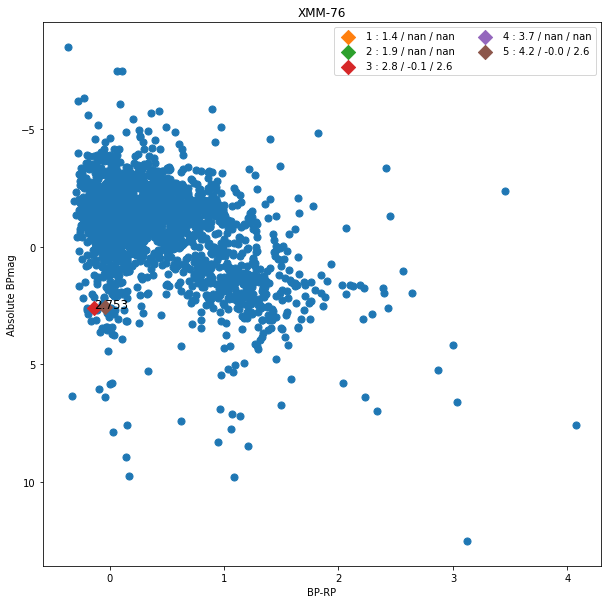

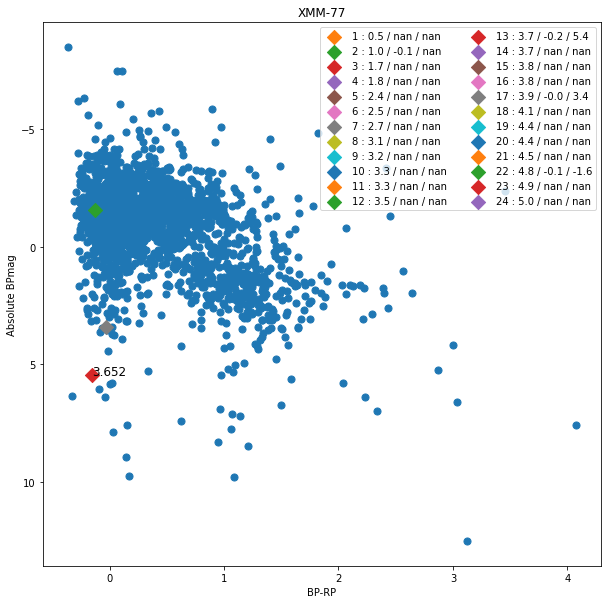

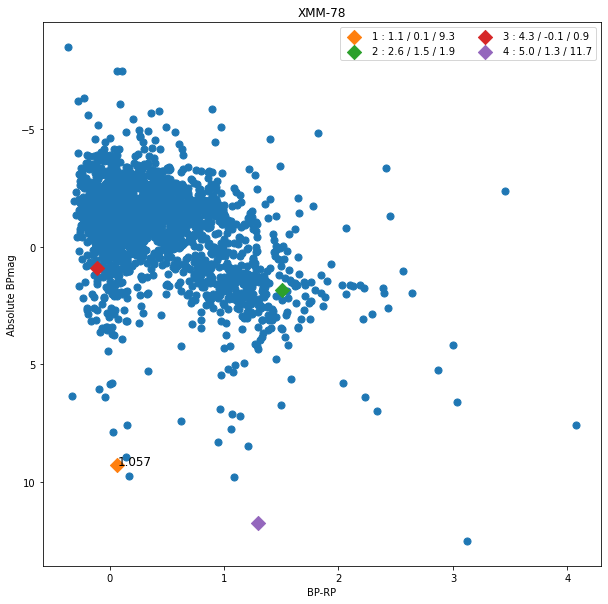

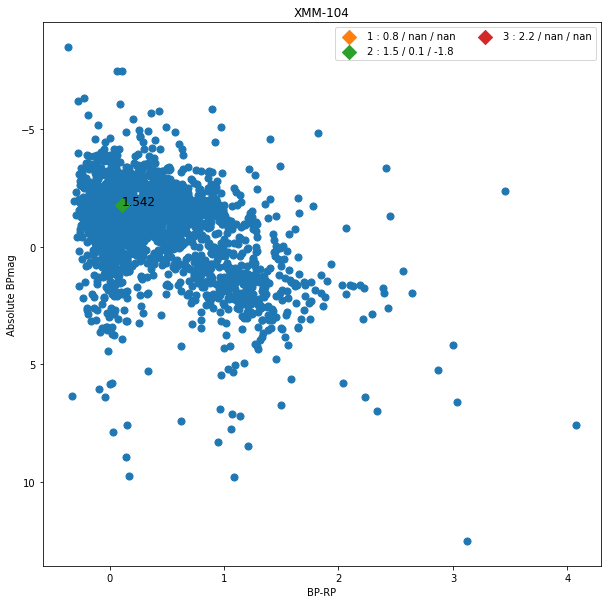

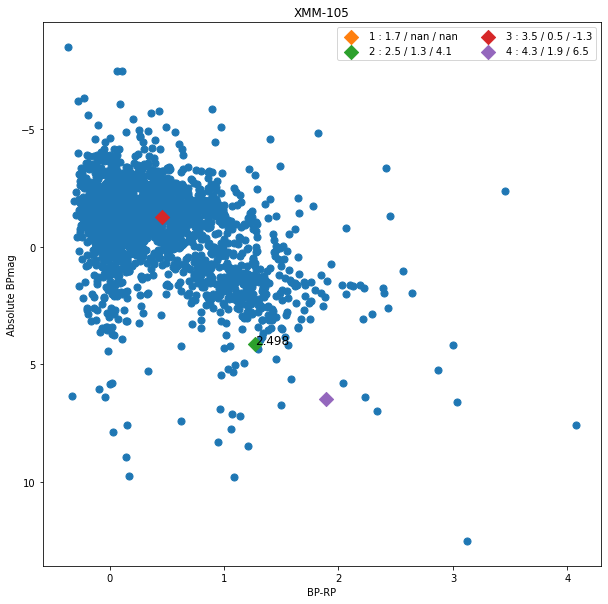

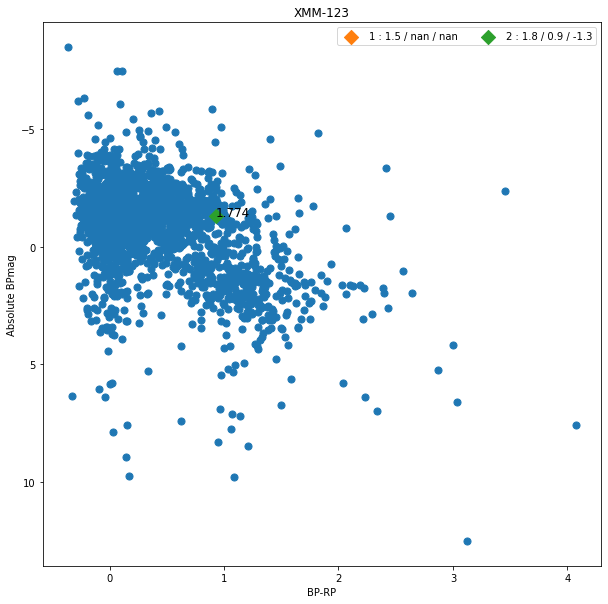

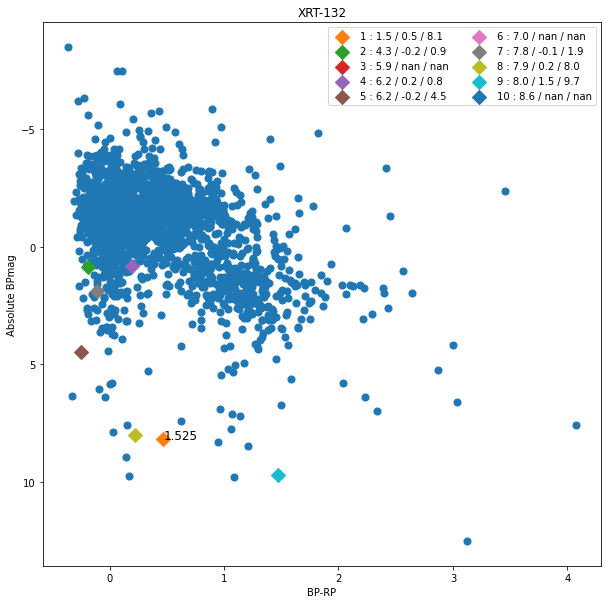

In [31]:
# marking questionable gaia counterparts of X-ray sources with multiple matches using conf_flag_X2O column 
# plotting the distributions of those questionable matches in HR diagram in diamonds compared to others in dots
# selecting the nearest gaia matches with valid color and distance measurements (plotted along with their separation in ")

X_gaia_select = pd.DataFrame()

for i in X_gaia['_q'].unique():

    df_sub = X_gaia.loc[X_gaia['_q']==i].sort_values(by=['_r'])
    instances = len(df_sub)
    if instances == 1:
        X_gaia_select = X_gaia_select.append(df_sub, ignore_index=True)
    else:
        df_src = df_sub.loc[df_sub['_r'] ==min(df_sub['_r'])]
        if len(df_src)>1:
            df_nearest = df_src.head(1)
        else:
            df_nearest = df_src
            
        if df_nearest['Source'].values in df_gaia['Source'].values:
            
            X_gaia_select = X_gaia_select.append(df_nearest, ignore_index=True)
        
        if df_nearest['Source'].values not in df_gaia['Source'].values:
            
            fig, ax = plt.subplots(figsize=(10,10))

            ax.scatter(df_gaia['BP-RP'], df_gaia['abs_BPmag'], s=50)

            j=1
            for s in df_sub.index:
                
                ax.scatter(df_sub.loc[s, 'BP-RP'], df_sub.loc[s,'abs_BPmag'], marker='D',s=100, label="%1d : %.1f / %.1f / %.1f" % (j, df_sub.loc[s,'_r_x'], df_sub.loc[s, 'BP-RP'], df_sub.loc[s,'abs_BPmag']))# str(j)+':'+str(df_sub.loc[s,'_r_x'])+'/'+str(df_sub.loc[s, 'BP-RP'])+'/'+str(df_sub.loc[s,'abs_BPmag']))
                
                j+=1
            
            df_sub_select = df_sub[(~df_sub['BP-RP'].isnull()) & (~df_sub['abs_BPmag'].isnull())].iloc[0]
            df_sub_select['conf_flag_X2O'] = 4
            X_gaia_select = X_gaia_select.append(df_sub_select, ignore_index=True)
            #print(df_sub_select)
            ax.text(df_sub_select['BP-RP'], df_sub_select['abs_BPmag'], str(df_sub_select['_r_x']), fontsize=12)
                
                
            plt.legend(ncol=2)
            plt.gca().invert_yaxis()
            plt.xlabel('BP-RP')
            plt.ylabel('Absolute BPmag')
            plt.title(xray.loc[i-1, 'X_pos']+'-'+str(int(i)))

In [32]:
# renaming some columns for gaia, xray and BeSS tables

pd.options.display.max_seq_items = 2000

X_gaia_select = X_gaia_select[['Source','_RAJ2000_x', '_DEJ2000_x','Plx', 'e_Plx', 'RPlx', 'PM', 'pmRA', 'e_pmRA', 'pmDE','e_pmDE','epsi','sepsi','RUWE',
                               'Gmag', 'e_Gmag','BPmag', 'e_BPmag','RPmag','e_RPmag',
                               'rgeo', 'b_rgeo', 'B_rgeo', 'rpgeo','b_rpgeo', 'B_rpgeo', 'Flag', 'abs_BPmag', '_q', '_r','conf_flag_X2O'
                              ]]
X_gaia_select = X_gaia_select.rename(columns={'_RAJ2000_x':'_RAJ2000_gaia', '_DEJ2000_x':'_DEJ2000_gaia','_q':'_q_X', '_r':'_r_X'})
#print(X_gaia_select.columns)


# xray = xray.drop(columns=['_RAJ2000_CSC', '_DEJ2000_CSC','_RAJ2000_XMM', '_DEJ2000_XMM','_RAJ2000_XRT', '_DEJ2000_XRT'])#.rename(columns={'_RAJ2000':'_RAJ2000_X', '_DEJ2000':'_DEJ2000_X'})
xray['index_X'] = xray.index+1
#print(xray.columns)


df_BeSS = df_BeSS[['#','Be star','V','Type','_RAJ2000', '_DEJ2000','conf_flag']].rename(columns={'Be star':'name_BeSS','V':'mag_BeSS','Type':'type_BeSS','_RAJ2000':'_RAJ2000_BeSS', '_DEJ2000':'_DEJ2000_BeSS'})
#print(df_BeSS.columns)

In [33]:
# merging all three (gaia, xray and BeSS) tables 

master = pd.merge(df_BeSS, xray, left_on='#', right_on='_q', how='inner')
#print(len(master))
master = pd.merge(master, X_gaia_select, left_on = 'index_X', right_on='_q_X', how='inner')
print(len(master))

145


## Matching with other multiwavelength catalogs (2mass, catwise, unwise, allwise) using 1" to gaia coordinates

In [34]:
master['_q_MW'] = master.index+1

cats = {
    'gaia':     'I/350/gaiaedr3',
    'gaiadist': 'I/352/gedr3dis',
    '2mass':    'II/246/out',
    'catwise':  'II/365/catwise',
    'unwise':   'II/363/unwise',
    'allwise':  'II/328/allwise',
    'vphas':   'II/341'
    }

ras = master['_RAJ2000_gaia'].values
decs = master['_DEJ2000_gaia'].values

radec = np.array([ras,decs]).T
rd = Table(Angle(radec, 'deg'), names=('_RAJ2000', '_DEJ2000'))

twomass = v.query_region(rd, catalog="II/246/out", radius="1s")[0].to_pandas()
twomass = find_nearest(twomass, ind_col='_q', sep_col='_r').reset_index(drop=True)
twomass = twomass[['_q', '_2MASS', 'Jmag', 'e_Jmag', 'Hmag', 'e_Hmag', 'Kmag', 'e_Kmag']].copy()

catwise = v.query_region(rd, catalog="II/365/catwise", radius="1s")[0].to_pandas()
catwise = find_nearest(catwise, ind_col='_q', sep_col='_r').reset_index(drop=True)

allwise = v.query_region(rd, catalog="II/328/allwise", radius="1s")[0].to_pandas()
allwise = find_nearest(allwise, ind_col='_q', sep_col='_r').reset_index(drop=True)

unwise = v.query_region(rd, catalog="II/363/unwise", radius="1s")[0].to_pandas()
unwise = find_nearest(unwise, ind_col='_q', sep_col='_r').reset_index(drop=True)

Before cleaning multiple matches: 136 rows.
After cleaning multiple matches: 136 rows.
Before cleaning multiple matches: 101 rows.
After cleaning multiple matches: 100 rows.
Before cleaning multiple matches: 113 rows.
After cleaning multiple matches: 113 rows.
Before cleaning multiple matches: 127 rows.
After cleaning multiple matches: 115 rows.


In [37]:
wise = pd.DataFrame(columns=["_q","W1","e_W1","W2","e_W2","W3","e_W3","W4","e_W4"])
for q in master["_q_MW"]:
    
    W1 = W2 = W3 = W4 = np.nan
    e_W1 = e_W2 = e_W3 = e_W4 = np.nan
    
    if (catwise["_q"] == q).any():
        W1 = catwise.loc[catwise["_q"]==q, "W1mproPM"].values[0]
        e_W1 = catwise.loc[catwise["_q"]==q, "e_W1mproPM"].values[0]
        W2 = catwise.loc[catwise["_q"]==q, "W2mproPM"].values[0]
        e_W2 = catwise.loc[catwise["_q"]==q, "e_W2mproPM"].values[0]
        
    elif (unwise["_q"] == q).any():
        FW1 = unwise.loc[unwise["_q"]==q, "FW1"].values[0]
        e_FW1 = unwise.loc[unwise["_q"]==q, "e_FW1"].values[0]
        FW2 = unwise.loc[unwise["_q"]==q, "FW2"].values[0]
        e_FW2 = unwise.loc[unwise["_q"]==q, "e_FW2"].values[0]
        W1 = 22.5 - 2.5*np.log10(FW1) - 0.004
        W2 = 22.5 - 2.5*np.log10(FW2) - 0.032
        e_W1 = -2.5*np.log10(np.e)*e_FW1/FW1
        e_W2 = -2.5*np.log10(np.e)*e_FW2/FW2
    
    if (allwise["_q"] == q).any():
        if pd.isna(W1):
            W1 = allwise.loc[allwise["_q"]==q, "W1mag"].values[0]
            e_W1 = allwise.loc[allwise["_q"]==q, "e_W1mag"].values[0]
        if pd.isna(W2):
            W2 = allwise.loc[allwise["_q"]==q, "W2mag"].values[0]
            e_W2 = allwise.loc[allwise["_q"]==q, "e_W2mag"].values[0]
        W3 = allwise.loc[allwise["_q"]==q, "W3mag"].values[0]
        e_W3 = allwise.loc[allwise["_q"]==q, "e_W3mag"].values[0]
        W4 = allwise.loc[allwise["_q"]==q, "W4mag"].values[0]
        e_W4 = allwise.loc[allwise["_q"]==q, "e_W4mag"].values[0]
        
    wise = wise.append(dict(zip(wise.columns, [q,W1,e_W1,W2,e_W2,W3,e_W3,W4,e_W4])), ignore_index=True)

df_MW = pd.merge(wise,twomass,on="_q",how="outer")
master = pd.merge(master,df_MW,left_on="_q_MW",right_on="_q",how="left")

In [38]:
# using rgeo for distance, correcting the distance for Gamma Cas

master['dist'] = master['rgeo']
master.loc[master['name_BeSS'] == 'gam Cas', 'dist'] = 168

In [39]:
# calculating some features 

master["HR_hms"] = (master['Flux (h band)'] - master['Flux (s band)'] - master['Flux (m band)']) / (master['Flux (h band)'] + master['Flux (s band)'] + master['Flux (m band)'])
master["HR_hm"] = (master['Flux (h band)'] - master['Flux (m band)']) / (master['Flux (h band)'] +  master['Flux (m band)'])
master["HR_ms"] = (master['Flux (m band)'] - master['Flux (s band)']) / (master['Flux (m band)'] + master['Flux (s band)'])

master["Gflux"] = (2.5e-9*10**(master["Gmag"]/(-2.5))) * 4052.97 

for band in "hms":
    master.loc[master[f"Flux ({band} band)"]==1.e-17,
               f"Flux ({band} band)"] = 0
master["Flux (b band)"] = master['Flux (h band)'] + master['Flux (s band)'] + master['Flux (m band)']

master['LX'] = master["Flux (b band)"] * 4 * np.pi * (master['dist']* 3.086e+18)**2 

master['X-O-fluxratio'] = master["Flux (b band)"]/ master["Gflux"]

master['BP-RP'] = master["BPmag"] - master["RPmag"]

master['ebv']  = master.apply(lambda row: DustMap.ebv(SkyCoord(row._RAJ2000_gaia, row._DEJ2000_gaia, unit = 'deg'), dustmap='SFD')*0.86, axis=1)
master['nH']   = master.apply(lambda row: GasMap.nh(SkyCoord(row._RAJ2000_gaia, row._DEJ2000_gaia, unit = 'deg'), nhmap='LAB').value/1.e21, axis=1)

In [40]:
# matching to Simbad using 2" 

master_simbad = XMatch.query(cat1=Table.from_pandas(master),
                             cat2='vizier:SIMBAD',max_distance=2 * u.arcsec,
                             colRA1='_RAJ2000_gaia',colDec1='_DEJ2000_gaia')

master_simbad = find_nearest(master_simbad.to_pandas(), ind_col='#', sep_col='angDist')

master = pd.merge(master, master_simbad[['#','main_type','main_id']],on="#",  how="outer")
print(len(master))

Before cleaning multiple matches: 141 rows.
After cleaning multiple matches: 136 rows.
145


In [41]:
# adding catalog memberships that each source is matched to 

for i in master.index:
    flags = []
    
    for col, cat in zip(["_2CXO","_4XMM","_2SXPS","Source","_2MASS","W1"], ["CSC","XMM","XRT","Gaia","2MASS","WISE"]):
        if pd.notna(master.loc[i,col]):
            flags.append(cat)
            
    master.loc[i,"Memberships"] = ",".join(flags)

In [42]:
master.drop(["Source","index_X",'Plx', 'e_Plx', 'RPlx', 'PM', 'Flag_y', 'conf_flag',
             '_q_x', '_q_X', '_r_X', 'conf_flag_X2O', '_q_MW', '_q_y',],axis=1,inplace=True)

In [40]:
# those sources have new CXO and XMM observations made 

#master.loc[master['name_BeSS']=='CD-29 5159', "Memberships"] = master.loc[master['name_BeSS']=='CD-29 5159', "Memberships"]+",CSC"
#master.loc[master['name_BeSS']=='EM* MWC 659', "Memberships"] = master.loc[master['name_BeSS']=='EM* MWC 659', "Memberships"]+",XMM"


# Adding classifications 

In [43]:
# assignning HMXB and YSO classifications based on Liu+2006 HMXB catalog and Simbad classifications

master_table = Table.from_pandas(master)
master_table["_RAJ2000"] = master_table["_RAJ2000_gaia"] *u.degree
master_table["_DEJ2000"] = master_table["_DEJ2000_gaia"] *u.degree

HMXBs_master = v.query_region(master_table, catalog="J/A+A/455/1165/table1", radius="1s")[0]

for i in master.index:
    if i+1 in (HMXBs_master['_q']):
        master.loc[i,'Class'] = 'HMXB'
    elif master.loc[i,'main_type'] == 'HMXB':
        master.loc[i,'Class'] = 'HMXB'
    elif master.loc[i,'main_type'] == 'Orion_V*' or master.loc[i,'main_type'] == 'YSO':
         master.loc[i,'Class'] = 'YSO'
    else:
        master.loc[i,'Class'] = 'star'
        
master['Class'].value_counts()

star    88
HMXB    49
YSO      8
Name: Class, dtype: int64

In [44]:
# assignning Gamma Cas Analogs classifications

gamma_cass = pd.read_csv("./GammaCassAnalogs.csv")

gamma_cass_coordinates = SkyCoord(gamma_cass['ra'], gamma_cass['dec'], frame='icrs',unit=(u.hourangle, u.deg))

gamma_cass['_RAJ2000'] = gamma_cass_coordinates.ra.degree
gamma_cass['_DEJ2000'] = gamma_cass_coordinates.dec.degree

for i in range(len(master)):
    c1 = SkyCoord(master.loc[i, '_RAJ2000_gaia']* u.degree, master.loc[i, '_DEJ2000_gaia']* u.degree, frame='icrs')
    
    sep = c1.separation(gamma_cass_coordinates).arcsec
    if min(sep)<1.:
        master.loc[i,'Class'] = r'$\gamma$ Cas analog'

master['Class'].value_counts()

star                   78
HMXB                   46
$\gamma$ Cas analog    13
YSO                     8
Name: Class, dtype: int64

In [45]:
# adding a few more 

master.loc[master['main_id'] == 'CD-29  5159', 'Class'] = 'HMXB'
master.loc[master['main_id'] == 'EM* MWC  659', 'Class'] = r'$\gamma$ Cas analog'
master.loc[master['main_id'] == '* pi. Aqr', 'Class'] = r'$\gamma$ Cas analog'
master.loc[master['main_id'] == 'HD  42054', 'Class'] = r'$\gamma$ Cas analog'

master['Class'].value_counts()

star                   74
HMXB                   47
$\gamma$ Cas analog    16
YSO                     8
Name: Class, dtype: int64

In [46]:
# adding HMGB classification
  
for name, coord in zip(['1FGL J1018.6−5856','4FGL J1405.1−6119','LS I +61 303','LS 2883','HESS J0632+057','LS 5039','TeV J2032+4130'],
                       [['10 19 02.270', '-58 56 29.87'], ['14 05 11.6', '-61 19 56'], ['02 40 31.6641883136', '+61 13 45.591138110'], ['13 02 47.6541729594','-63 50 08.62592286'], ['06 32 59.2566624297','+05 48 01.162565528'], ['18 26 15.0561532140', '-14 50 54.249464136'], ['20 32 06.0', '+41 34 00']]):
    HMGB_coordinates = SkyCoord(coord[0], coord[1], frame='icrs',unit=(u.hourangle, u.deg))
    #print(name, HMGB_coordinates)
    master_xray_coordinates = SkyCoord(master['_RAJ2000_gaia'], master['_DEJ2000_gaia'], frame='icrs',unit=(u.deg, u.deg))

    sep = HMGB_coordinates.separation(master_xray_coordinates).arcsec
    if min(sep)<1:
        #print(name, HMGB_coordinates,min(sep))
        ind = np.where(sep == min(sep))[0]
        #print(sep[ind])
        
        master.loc[ind,'Class'] = 'HMGB'
        master.loc[ind,'main_id'] = name
        
master['Class'].value_counts()

star                   74
HMXB                   44
$\gamma$ Cas analog    16
YSO                     8
HMGB                    3
Name: Class, dtype: int64

In [47]:
master.to_csv('XDBS_master.csv',index=False)

# Plotting

In [ ]:
fig, ax = plt.subplots(figsize=(15,12))#, facecolor="lightgrey")
#plt.grid(color="silver",linestyle=":")

ax.add_patch(mpl.patches.Rectangle((0,5e31),2.2,1e36, edgecolor='none',facecolor='lightgrey',zorder=0,alpha=1))

ax.add_patch(mpl.patches.Rectangle((-0.7,7e30),2.2,1e37, edgecolor='none',facecolor='lightgrey',zorder=0,alpha=0.3))

for model, pars, par_name, line, color in zip(['pl', 'gas'], [[0.5, 1.4, 2.4, 3], [0.5, 1, 2, 10]], [r'\Gamma', 'kT'], ['--','.'], ['b', 'k']):
    
    for par in pars:
        df = pd.read_csv('models/'+model+'_'+str(par)+'.csv')
        #print((df['f3']+df['f2']+df['f1'])*1e50)
        if model == 'pl':
            ax.plot( (df['f3']-df['f2']-df['f1'])/(df['f3']+df['f2']+df['f1']), (df['f3']+df['f2']+df['f1'])* 4 * np.pi * (3500* 3.086e+18)**2 * 20,line, color=color, label=model)
        elif model == 'gas':
            ax.plot( (df['f3']-df['f2']-df['f1'])/(df['f3']+df['f2']+df['f1']), (df['f3']+df['f2']+df['f1'])* 4 * np.pi * (3500* 3.086e+18)**2 /5e3,line, color=color, label=model)

ax.text(0.95, 4e32, 'kT=10', fontsize=12)
ax.text(0.95, 7e31, 'kT=2', fontsize=12)
ax.text(0.95, 1e31, 'kT=1', fontsize=12)
ax.text(0.8, 1e30, 'kT=0.5', fontsize=12)

ax.text(0.7, 6e34, '$\\Gamma$=0.5', fontsize=12, color='b')
ax.text(0.25, 2e34, '$\\Gamma$=1.4', fontsize=12, color='b')
ax.text(-0.55, 1e34, '$\\Gamma$=2.4', fontsize=12, color='b')
ax.text(-0.85, 1.5e34, '$\\Gamma$=3', fontsize=12, color='b')
    
for clas, color,marker,size in zip(['HMXB','HMGB','YSO','$\\gamma$ Cas analog','star' ], ['blue','cyan', 'red',  'magenta', 'green'], ['o', 'P', '^', 'D', '*'], [60, 120, 120, 100, 180]):
    sns.scatterplot(data=master_xray[(master_xray['Class']==clas)], x="HR_2-10_0.3-2", y="LX", color=color, marker=marker, s=size,linewidth=0, ax=ax, legend=True)
    ax.scatter(master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["HR_2-10_0.3-2"], master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["LX"], s=200, linewidth=1, facecolors='none', edgecolors="k")
    ax.scatter(master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["HR_2-10_0.3-2"], master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["LX"], marker='s', s=200, linewidth=1, facecolors='none', edgecolors="k")


for i in range(len(master_xray)):
    
    if (master_xray.loc[i, 'Class'] == 'HMGB'): 
        #print(master_xray.loc[i,['name','HR_2-10_0.3-2','LX']])
        ax.text(master_xray.loc[i,'HR_2-10_0.3-2']-0.01, master_xray.loc[i,'LX']*0.55, master_xray.loc[i,'main_id'], fontsize=12)
    if (master_xray.loc[i, 'name_BeSS'] == 'gam Cas'):
        #print(master_xray.loc[i,['name','HR_2-10_0.3-2','LX']])
        ax.text(master_xray.loc[i,'HR_2-10_0.3-2']+0.01, master_xray.loc[i,'LX']*0.65, r'$\gamma$ Cas', fontsize=12)

for i, src in zip(range(1,8), ['HD 298369', 'HD 248753', 'HD 237056', 'HD 305560', 'HD 228256', 'HD 166188', 'HD  19818']):
    #print(i, master_xray[master_xray['main_id']==src]['HR_2-10_0.3-2']-0.01)
    ax.text(master_xray.loc[master_xray['main_id']==src,'HR_2-10_0.3-2']-0.01, master_xray.loc[master_xray['main_id']==src,'LX']*1.4, str(i), fontsize=12)
    #print(i)
    

ax.set(ylim=(7e27,4e36), xlim=(-1.05,1.05),  yscale="log", xlabel=r'HR=(F$_{2-10}$-F$_{0.3-2}$)/(F$_{2-10}$+F$_{0.3-2}$)', ylabel=r"L$_X$(erg s$^{-1}$)")
ax.xaxis.get_label().set_fontsize(20)
ax.yaxis.get_label().set_fontsize(20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
legend_elements1 = [
                   Line2D([0], [0], linestyle="", marker='o', color='b', label='HMXB', markersize=8),
                   Line2D([0], [0], linestyle="", marker='P', color='cyan', label='HMGB', markersize=10),
                   Line2D([0], [0], linestyle="", marker='^', color='r', label='YSO', markersize=10),
                   Line2D([0], [0], linestyle="", marker='*', color='g', label='star', markersize=18),
                   Line2D([0], [0], linestyle="", marker='D', color='magenta', label=' $\\gamma$ Cas analog', markersize=10),
                   ]

legend_elements2 = [Line2D([0], [0], linestyle="", mfc="none", marker='o', color='k', label='XMM+CSC', markersize=15),
                   Line2D([0], [0], linestyle="", mfc="none", marker='s', color='k', label='XRT only', markersize=15),
                    Line2D([0], [0], linestyle="", mfc="none", marker='s', color='k', label='', markersize=0), 
                    Line2D([0], [0], linestyle="", mfc="none", marker='s', color='k', label='', markersize=0), 
                   ]
               
                
legend = ax.legend(handles=legend_elements1+legend_elements2, loc='upper left', ncol=2,fancybox=False, framealpha=0.6, fontsize=16)#, bbox_to_anchor=(1.15,1))
#legend = ax.legend(handles=legend_elements2, loc='upper left', ncol=2,fancybox=False, framealpha=0.6, fontsize=16)#, bbox_to_anchor=(1.15,1))


fig.savefig("plots/LX_vs_HR_BeSS.png",bbox_inches="tight",dpi=300)#,facecolor="lightgrey")

In [ ]:
fig, ax = plt.subplots(figsize=(15,12))#, facecolor="lightgrey")
for model, pars, par_name, line, color in zip(['pl', 'gas'], [[0.5, 1.4, 2.4, 3], [0.5, 1, 2, 10]], [r'\Gamma', 'kT'], ['--','.'], ['b', 'k']):
   
    for par in pars:
        df = pd.read_csv('models/'+model+'_'+str(par)+'.csv')
        #print((df['f3']+df['f2']+df['f1'])*1e50)
        ax.plot( (df['f2']-df['f1'])/(df['f2']+df['f1']), (df['f3']-df['f2'])/(df['f3']+df['f2']),line, color=color)
                   

ax.text(-0.1, 0.55, 'kT=10', fontsize=12)
ax.text(0., -0.1, 'kT=2', fontsize=12)
ax.text(-0.3, -0.55, 'kT=1', fontsize=12)
ax.text(-0.65, -0.8, 'kT=0.5', fontsize=12)

ax.text(0.25, 0.9, '$\\Gamma$=0.5', fontsize=12, color='b')
ax.text(-0.05, 0.65, '$\\Gamma$=1.4', fontsize=12, color='b')
ax.text(-0.5, 0.2, '$\\Gamma$=2.4', fontsize=12, color='b')
ax.text(-0.7, -0.1, '$\\Gamma$=3', fontsize=12, color='b')

for clas, color,marker,size in zip(['HMXB','HMGB','YSO','$\\gamma$ Cas analog','star' ], ['blue','cyan', 'red',  'magenta', 'green'], ['o', 'P', '^', 'D', '*'], [60, 120, 120, 100, 180]):
    sns.scatterplot(data=master_xray[(master_xray['Class']==clas)], x="HR_1-2_0.3-1", y="HR_2-10_1-2", color=color, marker=marker, s=size,linewidth=0, ax=ax, legend=True)
    
    ax.scatter(master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["HR_1-2_0.3-1"], master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["HR_2-10_1-2"], s=200, linewidth=1, facecolors='none', edgecolors="k")
    ax.scatter(master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["HR_1-2_0.3-1"], master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["HR_2-10_1-2"], marker='s', s=200, linewidth=1, facecolors='none', edgecolors="k")

for i in range(len(master_xray)):
    
    if (master_xray.loc[i, 'Class'] == 'HMGB'): 
        #print(master_xray.loc[i,['name','HR_2-10_0.3-2','LX']])
        ax.text(master_xray.loc[i,'HR_1-2_0.3-1']-0.01, master_xray.loc[i,'HR_2-10_1-2'], master_xray.loc[i,'main_id'], fontsize=12)
    if (master_xray.loc[i, 'name_BeSS'] == 'gam Cas'):
        #print(master_xray.loc[i,['name','HR_2-10_0.3-2','LX']])
        ax.text(master_xray.loc[i,'HR_1-2_0.3-1']+0.01, master_xray.loc[i,'HR_2-10_1-2'], r'$\gamma$ Cas', fontsize=12)

for i, src in zip(range(1,8), ['HD 298369', 'HD 248753', 'HD 237056', 'HD 305560', 'HD 228256', 'HD 166188', 'HD  19818']):
    ax.text(master_xray.loc[master_xray['main_id']==src,'HR_1-2_0.3-1']-0.01, master_xray.loc[master_xray['main_id']==src,'HR_2-10_1-2'], str(i), fontsize=12)
    #print(i)
    
ax.xaxis.get_label().set_fontsize(20)
ax.yaxis.get_label().set_fontsize(20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
legend_elements1 = [
                   Line2D([0], [0], linestyle="", marker='o', color='b', label='HMXB', markersize=8),
                   Line2D([0], [0], linestyle="", marker='P', color='cyan', label='HMGB', markersize=10),
                   Line2D([0], [0], linestyle="", marker='^', color='r', label='YSO', markersize=10),
                   Line2D([0], [0], linestyle="", marker='*', color='g', label='star', markersize=18),
                   Line2D([0], [0], linestyle="", marker='D', color='magenta', label=' $\\gamma$ Cas analog', markersize=10),
                   ]

legend_elements2 = [Line2D([0], [0], linestyle="", mfc="none", marker='o', color='k', label='XMM+CSC', markersize=15),
                   Line2D([0], [0], linestyle="", mfc="none", marker='s', color='k', label='XRT only', markersize=15),
                    Line2D([0], [0], linestyle="", mfc="none", marker='s', color='k', label='', markersize=0), 
                    Line2D([0], [0], linestyle="", mfc="none", marker='s', color='k', label='', markersize=0), 
                   ]

legend = ax.legend(handles=legend_elements1+legend_elements2, loc='lower right', ncol=2,fancybox=False, framealpha=0.6, fontsize=16)#, bbox_to_anchor=(1.15,1))

fig.savefig("plots/HR1_vs_HR2_BeSS.png",bbox_inches="tight",dpi=300)#,facecolor="lightgrey")

In [ ]:
fig, ax = plt.subplots(figsize=(15,12))#, facecolor="lightgrey")

ax.add_patch(mpl.patches.Rectangle((0,1e-4),1e5,1e37, edgecolor='none',facecolor='lightgrey',zorder=0,alpha=0.5))


for clas, color,marker,size in zip(['HMXB','HMGB','YSO','$\\gamma$ Cas analog','star' ], ['blue','cyan', 'red',  'magenta', 'green'], ['o', 'P', '^', 'D', '*'], [60, 120, 120, 100, 180]):
    sns.scatterplot(data=master_xray[(master_xray['Class']==clas)], x="dist", y="X-O-fluxratio", color=color, marker=marker, s=size,linewidth=0, ax=ax, legend=True)
    
    ax.scatter(master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["dist"], master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["X-O-fluxratio"], s=200, linewidth=1, facecolors='none', edgecolors="k")
    ax.scatter(master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["dist"], master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["X-O-fluxratio"], marker='s', s=200, linewidth=1, facecolors='none', edgecolors="k")

    
for i in range(len(master_xray)):
    
    if (master_xray.loc[i, 'Class'] == 'HMGB'): 
        ax.text(master_xray.loc[i,'dist'], master_xray.loc[i,'X-O-fluxratio']*0.5, master_xray.loc[i,'main_id'], fontsize=12)
    if (master_xray.loc[i, 'name_BeSS'] == 'gam Cas'):
        ax.text(master_xray.loc[i,'dist'], master_xray.loc[i,'X-O-fluxratio']*0.5, r'$\gamma$ Cas', fontsize=12)


    
ax.set(ylim=(1e-8,200), xlim=(100,40000), xscale="log", yscale="log", xlabel='distance(pc)', ylabel=r"$F_X/F_O$")
ax.xaxis.get_label().set_fontsize(20)
ax.yaxis.get_label().set_fontsize(20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
legend_elements = [Line2D([0], [0], linestyle="", mfc="none", marker='o', color='k', label='XMM+CSC', markersize=15),
                   Line2D([0], [0], linestyle="", mfc="none", marker='s', color='k', label='XRT only', markersize=15),
                   Line2D([0], [0], linestyle="", marker='o', color='b', label='HMXB', markersize=8),
                   Line2D([0], [0], linestyle="", marker='P', color='cyan', label='HMGB', markersize=10),
                   Line2D([0], [0], linestyle="", marker='^', color='r', label='YSO', markersize=10),
                   Line2D([0], [0], linestyle="", marker='*', color='g', label='star', markersize=18),
                   Line2D([0], [0], linestyle="", marker='D', color='magenta', label=' $\\gamma$ Cas analog', markersize=10),
                   #Line2D([0], [0], linestyle="", marker='o', mfc="none", mec='cyan', label='PMS', markersize=10, mew=2),
                   #mpl.patches.Patch(facecolor='lightgrey', edgecolor='none', label='$\epsilon>2,d<1$ kpc')
                   ]

legend = ax.legend(handles=legend_elements, loc='upper left', ncol=2,fancybox=False, framealpha=0.6, fontsize=16)#, bbox_to_anchor=(1.15,1))

fig.savefig("plots/fluxratio_vs_dist_BeSS.png",bbox_inches="tight",dpi=300)#,facecolor="lightgrey")

In [ ]:
fig, ax = plt.subplots(figsize=(15,12))#, facecolor="lightgrey")

for clas, color,marker,size in zip(['HMXB','HMGB','YSO','$\\gamma$ Cas analog','star' ], ['blue','cyan', 'red',  'magenta', 'green'], ['o', 'P', '^', 'D', '*'], [60, 120, 120, 100, 180]):
    sns.scatterplot(data=master_xray[(master_xray['Class']==clas)], x="BP-RP", y="X-O-fluxratio", color=color, marker=marker, s=size,linewidth=0, ax=ax, legend=True)
    
    ax.scatter(master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["BP-RP"], master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["X-O-fluxratio"], s=200, linewidth=1, facecolors='none', edgecolors="k")
    ax.scatter(master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["BP-RP"], master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["X-O-fluxratio"], marker='s', s=200, linewidth=1, facecolors='none', edgecolors="k")

    
for i in range(len(master_xray)):
    
    if (master_xray.loc[i, 'Class'] == 'HMGB'): 
        ax.text(master_xray.loc[i,'BP-RP'], master_xray.loc[i,'X-O-fluxratio']*0.5, master_xray.loc[i,'main_id'], fontsize=12)
    if (master_xray.loc[i, 'name_BeSS'] == 'gam Cas'):
        ax.text(master_xray.loc[i,'BP-RP'], master_xray.loc[i,'X-O-fluxratio']*0.5, r'$\gamma$ Cas', fontsize=12)


    
ax.set(ylim=(1e-8,200), xlim=(-1,4.3), yscale="log", xlabel=r'$G_{BP}-G_{RP}$', ylabel=r"$F_X/F_O$")
ax.xaxis.get_label().set_fontsize(20)
ax.yaxis.get_label().set_fontsize(20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
legend_elements = [Line2D([0], [0], linestyle="", mfc="none", marker='o', color='k', label='XMM+CSC', markersize=15),
                   Line2D([0], [0], linestyle="", mfc="none", marker='s', color='k', label='XRT only', markersize=15),
                   Line2D([0], [0], linestyle="", marker='o', color='b', label='HMXB', markersize=8),
                   Line2D([0], [0], linestyle="", marker='P', color='cyan', label='HMGB', markersize=10),
                   Line2D([0], [0], linestyle="", marker='^', color='r', label='YSO', markersize=10),
                   Line2D([0], [0], linestyle="", marker='*', color='g', label='star', markersize=18),
                   Line2D([0], [0], linestyle="", marker='D', color='magenta', label=' $\\gamma$ Cas analog', markersize=10),
                   #Line2D([0], [0], linestyle="", marker='o', mfc="none", mec='cyan', label='PMS', markersize=10, mew=2),
                   #mpl.patches.Patch(facecolor='lightgrey', edgecolor='none', label='$\epsilon>2,d<1$ kpc')
                   ]

legend = ax.legend(handles=legend_elements, loc='upper left', ncol=2,fancybox=False, framealpha=0.6, fontsize=16)#, bbox_to_anchor=(1.15,1))

#fig.savefig("plots/fluxratio_vs_dist_BeSS.png",bbox_inches="tight",dpi=300)#,facecolor="lightgrey")

In [ ]:
plt.figure(figsize=(8,6))

for clas, color in zip(['star','HMXB','HMGB','YSO','$\\gamma$ Cas analog', ], ['green','blue','cyan', 'red',  'magenta']):
    plt.hist(np.log10(master_xray.loc[(master_xray['Class']==clas) & (master_xray['X-O-fluxratio']>0),'X-O-fluxratio']), bins=20, alpha=0.5, color=color,label=clas)
    #plt.hist(np.log10(master_xray.loc[(master_xray['Class']=='$\\gamma$ Cas analog') & (master_xray['X-O-fluxratio']>0),'X-O-fluxratio']), bins=20, alpha=0.5, label="data1")
    #plt.hist(np.log10(master_xray.loc[(master_xray['Class']=='YSO') & (master_xray['X-O-fluxratio']>0),'X-O-fluxratio']), bins=20, alpha=0.5, color='r',label="data1")

#plt.hist(data2, bins=100, alpha=0.5, label="data2")

plt.xlabel("log($F_X/F_O$)", size=14)
plt.ylabel("Count", size=14)
plt.title("Multiple Histograms with Matplotlib")
plt.legend(loc='upper right')

In [ ]:
fig, ax = plt.subplots(figsize=(15,12))#, facecolor="lightgrey")


for clas, color,marker,size in zip(['HMXB','HMGB','YSO','$\\gamma$ Cas analog','star' ], ['blue','cyan', 'red',  'magenta', 'green'], ['o', 'P', '^', 'D', '*'], [60, 120, 120, 100, 180]):
    sns.scatterplot(data=master_xray[(master_xray['Class']==clas)], x="nH", y="X-O-fluxratio", color=color, marker=marker, s=size,linewidth=0, ax=ax, legend=True)
    
    ax.scatter(master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["nH"], master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["X-O-fluxratio"], s=200, linewidth=1, facecolors='none', edgecolors="k")
    ax.scatter(master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["nH"], master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas)]["X-O-fluxratio"], marker='s', s=200, linewidth=1, facecolors='none', edgecolors="k")

    
for i in range(len(master_xray)):
    
    if (master_xray.loc[i, 'Class'] == 'HMGB'): 
        #print(master_xray.loc[i,['name','HR_2-10_0.3-2','LX']])
        ax.text(master_xray.loc[i,'nH'], master_xray.loc[i,'X-O-fluxratio']*0.5, master_xray.loc[i,'main_id'], fontsize=12)
    if (master_xray.loc[i, 'name_BeSS'] == 'gam Cas'):
        #print(master_xray.loc[i,['name','HR_2-10_0.3-2','LX']])
        ax.text(master_xray.loc[i,'nH'], master_xray.loc[i,'X-O-fluxratio']*0.5, r'$\gamma$ Cas', fontsize=12)


    
ax.set(ylim=(1e-8,200), xlim=(0,20), yscale="log", xlabel='nH', ylabel=r"$F_X/F_O$")
ax.xaxis.get_label().set_fontsize(20)
ax.yaxis.get_label().set_fontsize(20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
legend_elements = [Line2D([0], [0], linestyle="", mfc="none", marker='o', color='k', label='XMM+CSC', markersize=15),
                   Line2D([0], [0], linestyle="", mfc="none", marker='s', color='k', label='XRT only', markersize=15),
                   Line2D([0], [0], linestyle="", marker='o', color='b', label='HMXB', markersize=8),
                   Line2D([0], [0], linestyle="", marker='P', color='cyan', label='HMGB', markersize=10),
                   Line2D([0], [0], linestyle="", marker='^', color='r', label='YSO', markersize=10),
                   Line2D([0], [0], linestyle="", marker='*', color='g', label='star', markersize=18),
                   Line2D([0], [0], linestyle="", marker='D', color='magenta', label=' $\\gamma$ Cas analog', markersize=10),
                   #Line2D([0], [0], linestyle="", marker='o', mfc="none", mec='cyan', label='PMS', markersize=10, mew=2),
                   #mpl.patches.Patch(facecolor='lightgrey', edgecolor='none', label='$\epsilon>2,d<1$ kpc')
                   ]

legend = ax.legend(handles=legend_elements, loc='upper left', ncol=2,fancybox=False, framealpha=0.6, fontsize=16)#, bbox_to_anchor=(1.15,1))

#fig.savefig("plots/fluxratio_vs_dist_BeSS.png",bbox_inches="tight",dpi=300)#,facecolor="lightgrey")

In [ ]:
fig, ax = plt.subplots(figsize=(15,12))#, facecolor="lightgrey")

for clas, color,marker,size in zip(['HMXB','HMGB','YSO','$\\gamma$ Cas analog','star' ], ['blue','cyan', 'red',  'magenta', 'green'], ['o', 'P', '^', 'D', '*'], [60, 120, 120, 100, 180]):
    sns.scatterplot(data=master_xray[(master_xray['Class']==clas) & (master_xray['sepsi']>5)], x="epsi", y="RUWE", color=color, marker=marker, s=size,linewidth=0, ax=ax, legend=True)
    
    ax.scatter(master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas) & (master_xray['sepsi']>5)]["epsi"], master_xray[(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas) & (master_xray['sepsi']>5)]["RUWE"], s=200, linewidth=1, facecolors='none', edgecolors="k")
    ax.scatter(master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas) & (master_xray['sepsi']>5)]["epsi"], master_xray[~(master_xray['Memberships'].str.contains('XMM|CSC')) & (master_xray['Class']==clas) & (master_xray['sepsi']>5)]["RUWE"], marker='s', s=200, linewidth=1, facecolors='none', edgecolors="k")


    
ax.set(xlim=(6e-2,10), ylim=(6e-1,60),  xscale="log", yscale="log", xlabel='epsi', ylabel="RUWE")
ax.xaxis.get_label().set_fontsize(20)
ax.yaxis.get_label().set_fontsize(20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
legend_elements = [Line2D([0], [0], linestyle="", mfc="none", marker='o', color='k', label='XMM+CSC', markersize=15),
                   Line2D([0], [0], linestyle="", mfc="none", marker='s', color='k', label='XRT only', markersize=15),
                   Line2D([0], [0], linestyle="", marker='o', color='b', label='HMXB', markersize=8),
                   Line2D([0], [0], linestyle="", marker='P', color='cyan', label='HMGB', markersize=10),
                   Line2D([0], [0], linestyle="", marker='^', color='r', label='YSO', markersize=10),
                   Line2D([0], [0], linestyle="", marker='*', color='g', label='star', markersize=18),
                   Line2D([0], [0], linestyle="", marker='D', color='magenta', label=' $\\gamma$ Cas analog', markersize=10),
                   #Line2D([0], [0], linestyle="", marker='o', mfc="none", mec='cyan', label='PMS', markersize=10, mew=2),
                   #mpl.patches.Patch(facecolor='lightgrey', edgecolor='none', label='$\epsilon>2,d<1$ kpc')
                   ]

legend = ax.legend(handles=legend_elements, loc='upper left', ncol=2,fancybox=False, framealpha=0.6, fontsize=16)#, bbox_to_anchor=(1.15,1))


#fig.savefig("plots/fluxratio_vs_dist_BeSS.png",bbox_inches="tight",dpi=300)#,facecolor="lightgrey")